## Analysis of Performance of Top and Bottom Weighted Dow Jones Stocks

### 1. Introduction

The Dow Jones Industrial Average (DJIA) was created in 1896 by Charles Dow, editor of The Wall Street Journal and founder of Dow Jones & Company. The DJIA is one of the main stock market indicators in the world, and is used to evaluate market movements and performance.
The index is compounded by 30 stocks that are selected by The Wall Street Journal editors and each company is weighted based on the price of its stock.
There are index funds linked to the DJIA that try to emulate its weights and performance, but you cannot invest directly in DJIA.

A subjective methodology for stock selection is that “A stock is typically added only if the company has an excellent reputation, demonstrates sustained growth and is of interest to a large number of investors". 

Therefore, there are 30 well selected companies that can be good investments, but should an individual investor follow the 30 companies and its weights, which can be time consuming and costly or there are ways to maximize the profitability of an investment using the DJIA as a guide and combine it with economical indicators?

The objective of this analysis is to look for patterns and correlations between DJIA main companies and economic indicators overtime. By identifying correlation between the US economy and stock performance, 


#### 1.1 Datasets Used
- Dow Jones List of Companies and Weighting (updated daily - Web Scrapping)
- Stock Market Monthly Time Series (updated monthly - API)
- US Market Confidence
- US Employability Index

#### 1.2 Research Questions
- Is there a correlation between key DJIA stocks and economic indicators?
- Is it possible to increase profitability by identifying short-term vs long-term correlation variances?
- If there are correlation variances comparing short-term vs long-term, can we use slope adjustment to calculate expected stock performance?

#### 1.3 Importing Packages

In [118]:
import pandas as pd # library for data analysis
from bs4 import BeautifulSoup # library to parse HTML documents
import requests as rq
import json
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from datetime import date
from dateutil.relativedelta import relativedelta

from functools import reduce

import scipy

from scipy.stats import linregress

#### 1.2 Create functions for use during analysis

In [119]:
#Function to import csv file extracted from OECD website
def df_oecd(path):
    ts_oecd=pd.read_csv(path)
    ts_oecd['Date']=ts_oecd['TIME']+'-01'
    ts_oecd['Date']=pd.to_datetime(ts_oecd['Date'])
    ts_oecd = ts_oecd[ts_oecd["LOCATION"] == 'USA']
    ts_oecd.sort_values(by=['Date'])
    ts_oecd.head()
    
    return ts_oecd;

#Function to import data from Alphavantage website based on DJIA Rank position (API)
def df_rank(rank):
    function='TIME_SERIES_MONTHLY'
    symbol=symb_list[rank]
    output_size='compact'
    data_type='json'
    api_key='M4HRU5SZA3C6D3MW'

    base_url = "https://www.alphavantage.co/query?"
    params = {"function":function, "symbol":symbol, "outputsize":output_size, "datatype":data_type, "apikey":api_key}

    response = rq.get(base_url, params=params)
    r=rq.get(base_url,params=params)
    data=r.json()

    ts = data.get("Monthly Time Series")
    ts=pd.DataFrame(ts)
    ts=ts.T
    ts['Symbol']=symbol
    ts['Date']=ts.index
    ts=ts.reset_index(drop=True)
    ts['Date']=ts['Date'].str[:4]+'-'+ts['Date'].str[5:7]
    ts['Date']=pd.to_datetime(ts['Date'])
    #ts.columns = ['Open','High','Low','Close','Volume','Symbol','Date']
    
    return ts;

#Function to import data from Alphavantage website based on stock Symbol
def df_symbol(symbol):

    function='TIME_SERIES_MONTHLY'
    symbol=symbol
    output_size='compact'
    data_type='json'
    api_key='M4HRU5SZA3C6D3MW'

    base_url = "https://www.alphavantage.co/query?"
    params = {"function":function, "symbol":symbol, "outputsize":output_size, "datatype":data_type, "apikey":api_key}

    response = rq.get(base_url, params=params)
    r=rq.get(base_url,params=params)
    data=r.json()

    ts_symb = data.get("Monthly Time Series")
    ts_symb=pd.DataFrame(ts_symb)
    ts_symb=ts_symb.T
    ts_symb['Symbol']=symbol
    ts_symb['Date']=ts_symb.index
    ts_symb=ts_symb.reset_index(drop=True)
    ts_symb['Date']=ts_symb['Date'].str[:4]+'-'+ts_symb['Date'].str[5:7]
    ts_symb['Date']=pd.to_datetime(ts_symb['Date'])
    ts_symb.columns = ['Open','High','Low','Close','Volume','Symbol','Date']

    return ts_symb

#Function to calculate and compare the correlation in different periods
def correl_index(index1,index2):
    long=scipy.stats.pearsonr(final_df[index1], final_df[index2])
    medium=scipy.stats.pearsonr(df_medium[index1], df_medium[index2])
    short=scipy.stats.pearsonr(df_short[index1], df_short[index2])
    
    return print("LT: "+str(round(long[0],2))+" MT: "+str(round(medium[0],2))+" ST: "+str(round(short[0],2)))

#Function to show correlation plot
def corr_plot(a,b):
     
    dfreg=final_df[[a,b]]
    dfreg=dfreg.dropna()
    dfstats=scipy.stats.pearsonr(dfreg[a], dfreg[b])
    g4=sns.jointplot(data=dfreg,x=a,y=b,kind="reg")
    g4.ax_joint.set_xlabel(a)
    g4.ax_joint.set_ylabel(b)

    plt.text(10,500,"pearsonr: "+str(round(dfstats[0],3)),fontsize=14)
    plt.text(10,440,"p-value: "+str(dfstats[1]),fontsize=14)

    plt.subplots_adjust(top=0.9)
    plt.suptitle(str(a)+" vs "+str(b),fontsize=16)
   
    return plt.show()

#### 1.4 Import Datasets

##### 1.4.1 DJIA Ranking - Wikipedia Daily Update

In [120]:
# Data collection using Web-Scrapping method
wiki="https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average#:~:text=The%20Dow%20Jones%20Industrial%20Average,exchanges%20in%20the%20United%20States."
table_class="mediawiki ltr sitedir-ltr mw-hide-empty-elt ns-0 ns-subject mw-editable page-Dow_Jones_Industrial_Average rootpage-Dow_Jones_Industrial_Average skin-vector action-view skin-vector-legacy"
response=rq.get(wiki)

#  Use BeautifulSoup to read html
soup = BeautifulSoup(response.text, 'html.parser')
dowtable=soup.find('table',{'class':"wikitable"})
wiki=pd.read_html(str(dowtable))

# Convert List to Dataframe and adapt data to fit the analysis needs
dj=pd.DataFrame(wiki[0])
dj['Weight'] = dj['Index weighting'].str.rstrip("%").astype(float)/100
dj['Rank'] = dj['Weight'].rank(ascending=False)
dj.sort_values(by=['Weight'])
dj_rank=dj.sort_values(by=['Rank'])
dj_rank = dj_rank.reset_index(drop=True)
dj_rank['Date']=dj_rank['Date added'].str[:4]+'-'+dj_rank['Date added'].str[5:7]+'-01'
dj_rank['Date']=pd.to_datetime(dj_rank['Date'])
symb_list = dj_rank.Symbol.values.tolist()
dj_rank.head(2)

,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting,Weight,Rank,Date
0,UnitedHealth,NYSE,UNH,Managed health care,2012-09-24,NaN,10.14%,0.1014,1.0,2012-09-01
1,Goldman Sachs,NYSE,GS,Financial services,2013-09-20,NaN,6.22%,0.0622,2.0,2013-09-01


##### 1.4.2 Stock Time Series - Data Import Function

In [122]:
# Create df for lowest weighted DJIA stock
ts_rank30=df_rank(29)
ts_rank30.head(2)

,1. open,2. high,3. low,4. close,5. volume,Symbol,Date
0,42.6300,45.2950,39.7150,43.8300,158871965,WBA,2022-05-01
1,44.5400,47.2750,42.3400,42.4000,154101958,WBA,2022-04-01


In [125]:
# Create df for DIA (DJIA index fund)
ts_dia=df_symbol('DIA')
ts_dia.head(2)

,Open,High,Low,Close,Volume,Symbol,Date
0,330.3500,341.1700,306.2800,330.2000,125388059,DIA,2022-05-01
1,348.1500,354.8783,329.1000,329.6900,103440368,DIA,2022-04-01


In [126]:
# Create df for heighest weighted DJIA stock
ts_rank1=df_rank(0)
ts_rank1.head(2)

,1. open,2. high,3. low,4. close,5. volume,Symbol,Date
0,510.8100,513.5100,463.3300,496.7800,67952080,UNH,2022-05-01
1,510.6800,553.2900,504.5301,508.5500,61044463,UNH,2022-04-01


In [127]:
#Create dataframes from OECD stats (csv)
bci=r"C:\Users\eduar\OneDrive\Documents\Master of Analytics\Intro to Analytics\Assignment 3_4\BCI_US.csv";
ts_bci=df_oecd(bci)

emp=r"C:\Users\eduar\OneDrive\Documents\Master of Analytics\Intro to Analytics\Assignment 3_4\EMP_US.csv";
ts_emp=df_oecd(emp)

In [145]:
#Merge all dataframes created using Date as join key

dfs = [ts_bci, ts_emp, ts_dia, ts_rank1, ts_rank30]
final_df = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],how='inner'), dfs)



In [147]:
final_df.to_csv(r"C:\Users\eduar\OneDrive\Documents\Master of Analytics\Intro to Analytics\Assignment 3_4\final.csv")

In [148]:
#Select relevant columns for analysis, creating a complete dataset with all information used on this analysis

final_df=final_df[['Date','Value_x','Value_y','Open','High','Low','Close','Volume','1. open_x','2. high_x','3. low_x','4. close_x','5. volume_x','1. open_y','4. close_y','5. volume_y']]
final_df.columns=['Date','BCI','EMP','DIA_Open','DIA_High','DIA_Low','DIA_Close','DIA_Volume','First_Open','First_High','First_Low','First_Close','First_Volume','Last_Open','Last_Close','Last_Vol']
final_df['Year']=pd.DatetimeIndex(final_df['Date']).year


#Convert all columns to float
cols = ['DIA_Open','DIA_High','DIA_Low','DIA_Close','DIA_Volume','First_Open','First_Close','First_Volume','Last_Open','Last_Close','Last_Vol']
final_df[cols] = final_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
final_df.head(2)

,Date,BCI,EMP,DIA_Open,DIA_High,DIA_Low,DIA_Close,DIA_Volume,First_Open,First_High,First_Low,First_Close,First_Volume,Last_Open,Last_Close,Last_Vol,Year
0,2008-01-01,99.08396,71.67984,132.47,132.67,115.80,126.00,473724100.0,57.19,57.8600,48.1200,50.84,191989500.0,37.99,35.04,201483400.0,2008
1,2008-02-01,98.98666,71.43710,126.49,127.61,120.76,123.01,279035500.0,50.36,51.0300,44.0000,46.48,156703700.0,34.95,36.51,120248100.0,2008


##### Variables Index
BCI - Business Confidence Index<br>
EMP - Employment Rate<br>
DIA - SPDR Dow Jones Industrial Average ETF Trust<br>
First - Heighest Ranked DJIA Stock based on Weight<br>
Last - Lowest Ranked DJIA Stock based on Weight

Open - Stock Price Start of the month
High - Highest Stock Price during the month
Low - Lowest Stock Price during the month
Close - Stock Price End of the month
Volume - Volume traded during the month

### 2. Data Visualization

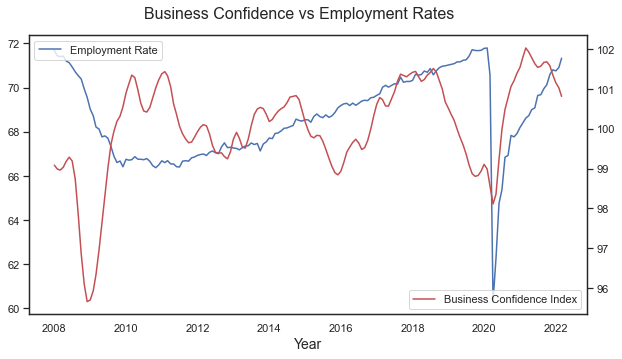

In [149]:
fig,ax = plt.subplots()

plt.subplots_adjust(top=0.9)
plt.suptitle('Business Confidence vs Employment Rates', fontsize = 16)

fig.set_size_inches(10,5, forward=True)
# make a plot
ax.plot(final_df['Date'], final_df['EMP'], "-b", label="Employment Rate")
# set x-axis label
ax.set_xlabel("Year",fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(final_df['Date'], final_df['BCI'], "-r", label="Business Confidence Index")

ax.legend(loc="upper left")
ax2.legend(loc="lower right");


#### First we are exploring the movements in Business Confidence Level and the Employment Rates
##### It is possible to see that in 2009 there was a quick drop in BCI followed by a decrease in Employment rates, and the same happening in 2020, with major changes in both BCI and Employment Rates at the same time.

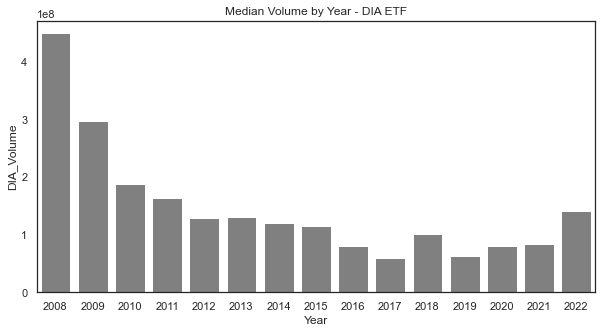

In [150]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("white")

dia_med = final_df.groupby('Year').median()
dia_med['Year']=dia_med.index
dia_med=dia_med.reset_index(drop=True)
dia_med.head()

ax1 = sns.barplot(x="Year", y="DIA_Volume", data=dia_med,color="gray").set(title='Median Volume by Year - DIA ETF')

#### After 2008, DIA median volume traded decreased year after year, but has been showing a slight increase after 2019.

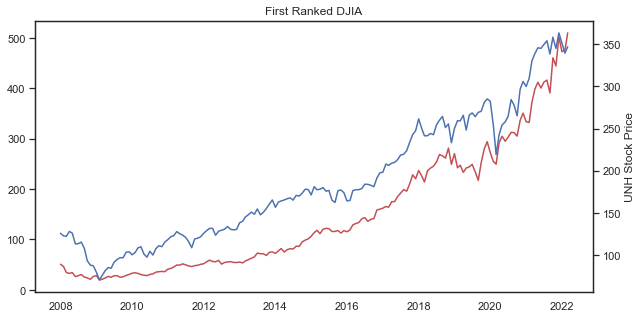

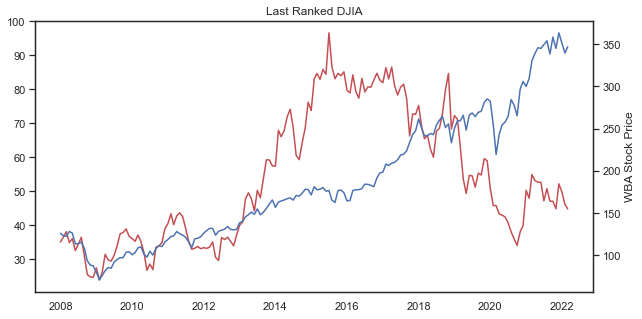

In [151]:
first=symb_list[0]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(final_df['Date'], final_df['First_Close'], color="r")
ax2.plot(final_df['Date'], final_df['DIA_Close'])
plt.title('First Ranked DJIA')
plt.xlabel('Year')
plt.ylabel(first+' Stock Price')
plt.show()


fig, ax1 = plt.subplots()
last=symb_list[29]
ax2 = ax1.twinx()
ax1.plot(final_df['Date'], final_df['Last_Close'], color="r",label="x^2")
ax2.plot(final_df['Date'], final_df['DIA_Close'])
plt.title('Last Ranked DJIA')
plt.xlabel('Year')
plt.ylabel(last+' Stock Price')
plt.show()

Above we can observe that DIA and the Highest Ranked Stock in DJIA (UNH as at 31st May 2022) have similar movements overtime, while DIA and the Lowest Ranked Stock (WBA) had a high correlation between 2008 and 2013 but after this the variances increased and the correlation is lower than before.

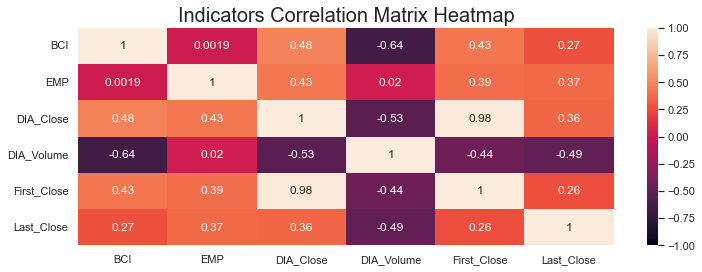

In [152]:
corr_df=final_df[['BCI','EMP','DIA_Close','DIA_Volume','First_Close','Last_Close']]
corr_df.corr()
plt.figure(figsize=(12, 4))
sns.heatmap(corr_df.corr(), vmin=-1, vmax=1, annot=True)
plt.title("Indicators Correlation Matrix Heatmap",fontsize=20);

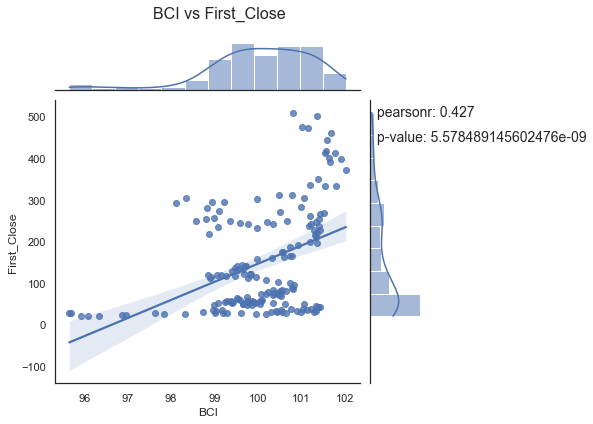

In [153]:
corr_plot('BCI','First_Close')

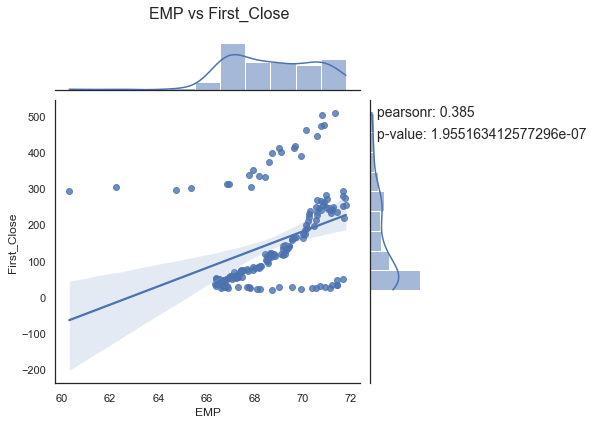

In [154]:
corr_plot('EMP','First_Close')

Considering that UNH and WBA are part of the index that compound DIA, we shouldn't consider their high correlation with DIA identified for our analysis.<br>
Therefore, we should only focus on the correlation between BCI/EMP vs DIA, First Ranked (UNH) and Last Ranked (WBA) information.<br>
<br>
BCI and EMP have moderate positive correlation with First_Close and DIA_Close when analysing the entire period with data available for all instances (2008 - 2022)<br>

Is the long-term moderate correlation identified in the short-term as well?

#### Create Short-Term and Medium-Term Dataframe

In [155]:
one_year =  pd.to_datetime(date.today() + relativedelta(years=-1))
five_years =  pd.to_datetime(date.today() + relativedelta(years=-5))
df_short=final_df[final_df['Date']>one_year]
df_medium=final_df[final_df['Date']>five_years]

In [156]:
correl_index('BCI','First_Close')

LT: 0.43 MT: 0.33 ST: -0.75


We can see that there is a high variance when we compare the Long Term/ Med Term vs Short Term correlation between BCI and First_Close.<br><br>

There is a 0.43 pearsonr on the Long-term, while the correlation is -0.75 in the short-term.

In [157]:
a=final_df['BCI']
b=final_df['Year']
c=df_short['BCI']
d=df_short['Year']

lp_slope=linregress(a, b)[0]
st_slope=linregress(c, d)[0]

print("The long-term slope is: "+str(round(lp_slope,2)))
print("The short-term slope is: "+str(round(st_slope,2)))

The long-term slope is: 1.47
The short-term slope is: -1.47


Above we can see that there is a complete opposite direction and intensity of the short-term slope compared to the long-term slope

In [158]:
a=final_df['First_Close']
b=final_df['Year']
c=df_short['First_Close']
d=df_short['Year']

lp_slope=linregress(a, b)[0]
st_slope=linregress(c, d)[0]
print("The long-term slope is: "+str(round(lp_slope,2)))
print("The short-term slope is: "+str(round(st_slope,2)))

The long-term slope is: 0.03
The short-term slope is: 0.01


In [159]:
correl_index('EMP','First_Close')

LT: 0.39 MT: -0.14 ST: 0.88


In [160]:
a=final_df['EMP']
b=final_df['Year']
c=df_short['EMP']
d=df_short['Year']

lp_slope=linregress(a, b)[0]
st_slope=linregress(c, d)[0]
print("The long-term slope is: "+str(round(lp_slope,2)))
print("The short-term slope is: "+str(round(st_slope,2)))

The long-term slope is: 0.75
The short-term slope is: 0.62


The hypothesis of a short-term correlation tending to an adjustment to the long-term correlation can be used as an investment strategy when we analyse independent variables, such as the Business Confidence Index and an important stock such as the heighest weighted DJIA stock.

Above, running the correlation between Economic Indicators and Stock movement for two types of periods (Long Term and Short Term) we tested if there were high variances between the two correlations found.<br>
<br> This is only an indication that we can potentially explore these variances between long vs short term correlation to trigger an investment.<br><br>
The idea is, if we identify that the short-term correlation between a stock and an economic indicator is highly different than the same pair when analysed in the long term, we have the potential of a profitable investment considering that the correlation will tend to its long term pattern.

### Testing Hypothesis - One Year

In [164]:
year=2011

#Create long-term dataframe from start to selected year
lt=final_df[final_df['Year']<=year]

#Create short-term dataframe for the selected year
st=final_df[final_df['Year']==year]

#Create dataframe for after the selected year
aft=final_df[final_df['Year']>year]

#Calculate stats for long-term, short-term and period after selected year
statlt=linregress(lt['BCI'], lt['First_Close'])[2]
statst=linregress(st['BCI'], st['First_Close'])[2]
stataft=linregress(aft['BCI'], aft['First_Close'])[2]
stockslopelt=linregress(lt['First_Close'], lt['Year'])[0]
stockslopest=linregress(st['First_Close'], st['Year'])[0]
stockslopeaft=linregress(aft['First_Close'], aft['Year'])[0]
 
print("While there is a " + str(round(statlt,2)) + " correlation between BCI and UNH in the long-term analysis, there is a "+ str(round(statst,2))+ " correlation when we observe the short-term.")

While there is a 0.5 correlation between BCI and UNH in the long-term analysis, there is a -0.61 correlation when we observe the short-term.


Considering that the discrepancy between short and long term correlations could trigger an investment, below we evaluate the stock price movement after the selected year and also its correlation with the Business Confidence Index

In [165]:
print("BCI and UNH after the selected year have a correlation of "+str(round(stataft,2)))
print("The slope turned from "+str(round(stockslopest,2))+" in the short term to "+str(round(stockslopeaft,2))+" after the selected year")

BCI and UNH after the selected year have a correlation of 0.47
The slope turned from 0.0 in the short term to 0.02 after the selected year


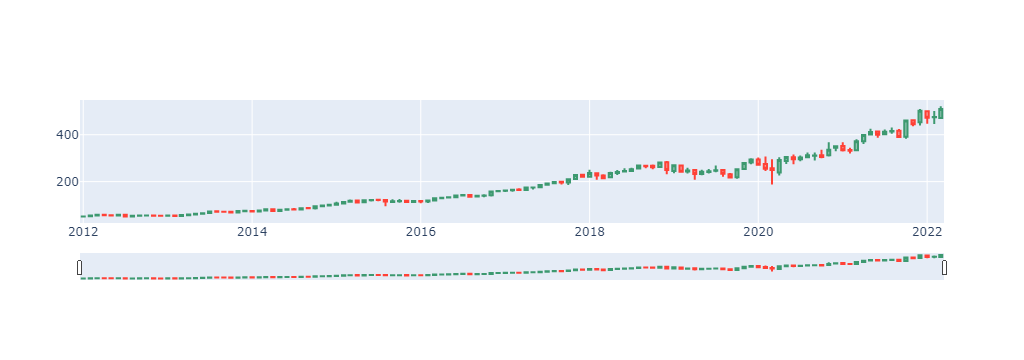

In [166]:
fig = go.Figure(data=[go.Candlestick(x=aft['Date'],
                open=aft['First_Open'],
                high=aft['First_High'],
                low=aft['First_Low'],
                close=aft['First_Close'])])

fig.show()

### 3. Conclusion

### 4. References

### 5. csv Extraction